In [50]:
import datetime as datetime
import datetime 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import string
import unidecode


import sklearn as sk
import xgboost
import category_encoders as ce

from matplotlib import pyplot
from sklearn.utils import shuffle
from numpy import sort
from matplotlib import pyplot
from xgboost import plot_importance

from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold

from sklearn.metrics import accuracy_score, r2_score, classification_report, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LogisticRegression

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier

from sklearn.preprocessing import StandardScaler
from lightgbm.sklearn import LGBMClassifier

In [51]:
train = pd.read_csv('../../train.csv', low_memory=False)

In [52]:
train["text"] = train["text"].str.lower()
train["text"] = train["text"].apply(lambda x: re.sub('(?P<url>https?://[^\s]+)', ' ', x))
train["text"] = train["text"].apply(lambda x: re.sub(r'[^\w]', ' ', x))
train["text"] = train["text"].apply(lambda x: re.sub(r'_', ' ', x))
train["text"] = train["text"].apply(lambda x: re.sub(r'[0-9]',' ', x))
train["text"] = train["text"].apply(lambda x: re.sub(' +',' ', x))
train["text"] = train["text"].apply(lambda x: unidecode.unidecode(x))
train["text"] = train["text"].str.strip()
train["text_length"] = train["text"].str.len()
train["text"] = train["text"].apply(lambda x: re.sub(r'\b\w{1}\b', '', x))
train["words_count"] = train["text"].str.split(' ').apply(lambda x: len(x))

train["keyword"] = train["keyword"].str.replace('%20',' ')

In [53]:
encoder = ce.HashingEncoder(cols=['keyword'])
trainbin = encoder.fit_transform(train['keyword'])
hashing = pd.concat([train, trainbin], axis=1)
hashing

,id,keyword,location,text,target,text_length,words_count,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1,68,13,1,0,0,0,0,0,0,0
1,4,NaN,NaN,forest fire near la ronge sask canada,1,37,7,1,0,0,0,0,0,0,0
2,5,NaN,NaN,all residents asked to shelter in place are be...,1,130,22,1,0,0,0,0,0,0,0
3,6,NaN,NaN,people receive wildfires evacuation orders in ...,1,56,7,1,0,0,0,0,0,0,0
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1,85,16,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,two giant cranes holding bridge collapse into...,1,60,10,1,0,0,0,0,0,0,0
7609,10870,NaN,NaN,aria ahrary thetawniest the out of control wil...,1,121,21,1,0,0,0,0,0,0,0
7610,10871,NaN,NaN,utc km of volcano hawaii,1,28,7,1,0,0,0,0,0,0,0
7611,10872,NaN,NaN,police investigating after an bike collided w...,1,135,22,1,0,0,0,0,0,0,0


In [54]:
data = hashing.drop(["id","location","text","target", "keyword"], axis=1)
target = hashing["target"]

In [55]:
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size = 0.25)

In [64]:
# feature selection
def select_features(x_train, y_train, x_test):
    fs = SelectKBest(score_func=chi2, k=4)
    fs.fit(x_train, y_train)
    x_train_fs = fs.transform(x_train)
    x_test_fs = fs.transform(x_test)
    return x_train_fs, x_test_fs, fs

In [65]:
x_train_fs, x_test_fs, fs = select_features(x_train, y_train, x_test)

In [62]:
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))

Feature 0: 546.382692
Feature 1: 0.109145
Feature 2: 0.256171
Feature 3: 52.521594
Feature 4: 0.005033
Feature 5: 1.015892
Feature 6: 2.568913
Feature 7: 61.119659
Feature 8: 1.120627
Feature 9: 8.021215


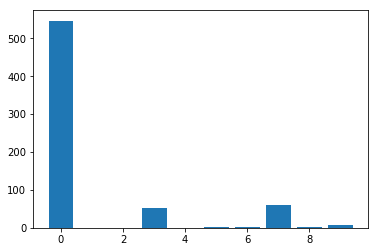

In [63]:
# plot the scores
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()

In [70]:
# feature selection
def select_features2(x_train, y_train, x_test):
    fs2 = SelectKBest(score_func=mutual_info_classif, k=7)
    fs2.fit(x_train, y_train)
    x_train_fs2 = fs2.transform(x_train)
    x_test_fs2 = fs2.transform(x_test)
    return x_train_fs2, x_test_fs2, fs2

In [71]:
x_train_fs2, x_test_fs2, fs2 = select_features2(x_train, y_train, x_test)

In [68]:
# what are scores for the features
for i in range(len(fs2.scores_)):
    print('Feature %d: %f' % (i, fs2.scores_[i]))

Feature 0: 0.017130
Feature 1: 0.009904
Feature 2: 0.000000
Feature 3: 0.006863
Feature 4: 0.009763
Feature 5: 0.000000
Feature 6: 0.014068
Feature 7: 0.010460
Feature 8: 0.000000
Feature 9: 0.008094


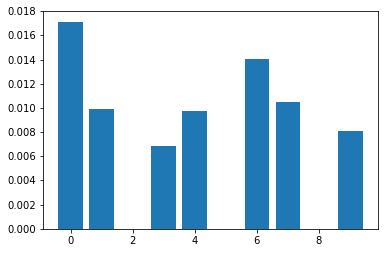

In [69]:
# plot the scores
pyplot.bar([i for i in range(len(fs2.scores_))], fs2.scores_)
pyplot.show()

In [72]:
# fit the model
model = LogisticRegression(solver='lbfgs')
model.fit(x_train, y_train)
# evaluate the model
yhat = model.predict(x_test)
# evaluate predictions
accuracy = accuracy_score(y_test, yhat)
print('Accuracy: %.2f' % (accuracy*100))

Accuracy: 62.50


In [73]:
# fit the model
model2 = LogisticRegression(solver='lbfgs')
model2.fit(x_train_fs, y_train)
# evaluate the model
yhat2 = model2.predict(x_test_fs)
# evaluate predictions
accuracy2 = accuracy_score(y_test, yhat2)
print('Accuracy: %.2f' % (accuracy2*100))

Accuracy: 57.67


In [74]:
# fit the model
model3 = LogisticRegression(solver='lbfgs')
model3.fit(x_train_fs2, y_train)
# evaluate the model
yhat3 = model3.predict(x_test_fs2)
# evaluate predictions
accuracy3 = accuracy_score(y_test, yhat3)
print('Accuracy: %.2f' % (accuracy3*100))

Accuracy: 57.04
